In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import from_json, split, col, from_unixtime, rpad,avg, sum, count
import plotly.express as px
import nbformat
import kagglehub

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spark = SparkSession.builder.appName("cc_numbers").getOrCreate()
# spark = SparkSession.builder.master("local[*]").appName("MyApp").getOrCreate()
path = kagglehub.dataset_download("jinquan/cc-sample-data")
path = path + '\\cc_sample_transaction.json'
df = spark.read.json(path)
rename_map = {
"Unnamed: 0": "id",
"trans_date_trans_time": "transaction_time",
"cc_num": "credit_card_number",
"merchant": "merchant_name",
"category": "merchant_category",
"amt": "transaction_amount",
"first": "first_name",
"last": "last_name",
"gender": "gender",
"street": "street_address",
"city": "city",
"state": "state",
"zip": "zip_code",
"lat": "latitude",
"long": "longitude",
"city_pop": "city_population",
"job": "job_title",
"dob": "date_of_birth",
"trans_num": "transaction_number",
"merch_lat": "merchant_latitude",
"merch_long": "merchant_longitude",
"is_fraud": "fraud_indicator",
"merch_zipcode": "merchant_zipcode",
"merch_last_update_time": "merchant_last_update_time",
"merch_e?_time": "merchant_effective_time",
"cc_bic": "credit_card_bic"
}

if "personal_detail" in df.columns:
    field_type = [field.dataType for field in df.schema.fields if field.name == "personal_detail"][0]
    print("personal_detail type:", field_type)
    
    personal_detail_schema = StructType([
        StructField("person_name", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("address", StringType(), True),
        StructField("lat", StringType(), True),
        StructField("long", StringType(), True),
        StructField("city_pop", StringType(), True),
        StructField("job", StringType(), True),
        StructField("dob", StringType(), True),
        # add more fields as needed
    ])
    address_schema = StructType([
        StructField("street", StringType(), True),
        StructField("city", StringType(), True),
        StructField("state", StringType(), True),
        StructField("zip", StringType(), True),

    ])
    df = df.withColumn("personal_detail_struct", from_json(col("personal_detail"), personal_detail_schema))
    df = df.select("*", "personal_detail_struct.*").drop("personal_detail_struct",'personal_detail')
    df = df.withColumn("address_struct", from_json(col("address"), address_schema))
    df = df.select("*", "address_struct.*").drop("address_struct",'address')

df = df.withColumn("first_name", split(df["person_name"], r"\W+")[0]) \
       .withColumn("last_name", split(df["person_name"], r"\W+")[1])

df = df.withColumn("merch_last_update_time", rpad(df['merch_last_update_time'],13,'0'))
df = df.withColumn("merch_eff_time", rpad(df['merch_eff_time'],13,'0'))

df = df.withColumn("merch_last_update_time_updated", from_unixtime(col("merch_last_update_time") / 1000))
df = df.withColumn("merch_eff_time_updated", from_unixtime(col("merch_eff_time") / 1000))

personal_detail type: StringType()


In [18]:
df1 = df.filter(df['is_fraud'] == '1')

In [3]:
df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+--------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+-----------+---------+------------------------------+----------------------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time|merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |person_name              |gender|lat    |long              |city_pop|job                                          |dob       |street                        |city                    |state|zip  |first_name |las

In [20]:
agg_df = df.groupBy("category").agg(avg("amt").alias("avg_amount"))
agg_df1 = df.groupBy("category").agg(sum("amt").alias("sum"))
agg_df2 = df.groupBy("category").agg(count("trans_num").alias("count"))
agg_df3 = df.groupBy("state").agg(count("trans_num").alias("count"))
agg_df4 = df.groupBy("category",'gender').agg(avg("amt").alias("avg_amount"))
agg_df5 = df.groupBy("category",'gender').agg(sum("amt").alias("sum"))
agg_df6 = df.groupBy("category",'gender').agg(count("trans_num").alias("count"))
agg_df7 = df1.groupBy("category",'is_fraud').agg(count("trans_num").alias("count"))
agg_df8 = df1.groupBy("state",'is_fraud').agg(count("trans_num").alias("count"))

In [21]:
pd_df = agg_df.toPandas()
sum_df = agg_df1.toPandas()
count_df = agg_df2.toPandas()
state_df = agg_df3.toPandas()
mf_df = agg_df6.toPandas()
fr_c_df = agg_df7.toPandas()
fr_s_df = agg_df8.toPandas()

In [11]:
pd_df = pd.merge(pd_df,sum_df,how='inner',on='category')
pd_df = pd.merge(pd_df,count_df,how='inner',on='category')

In [12]:
pd_df

,category,avg_amount,sum,count
0,travel,111.504720,4516721.68,40507
1,misc_net,80.865095,5117709.26,63287
2,grocery_pos,116.960986,14460822.38,123638
3,kids_pets,57.536871,6503680.16,113035
4,shopping_net,88.424076,8625149.68,97543
5,grocery_net,53.670084,2439412.68,45452
6,food_dining,51.086905,4672459.44,91461
7,gas_transport,63.434572,8351732.29,131659
8,personal_care,47.967678,4353450.53,90758
9,health_fitness,54.182140,4653108.02,85879


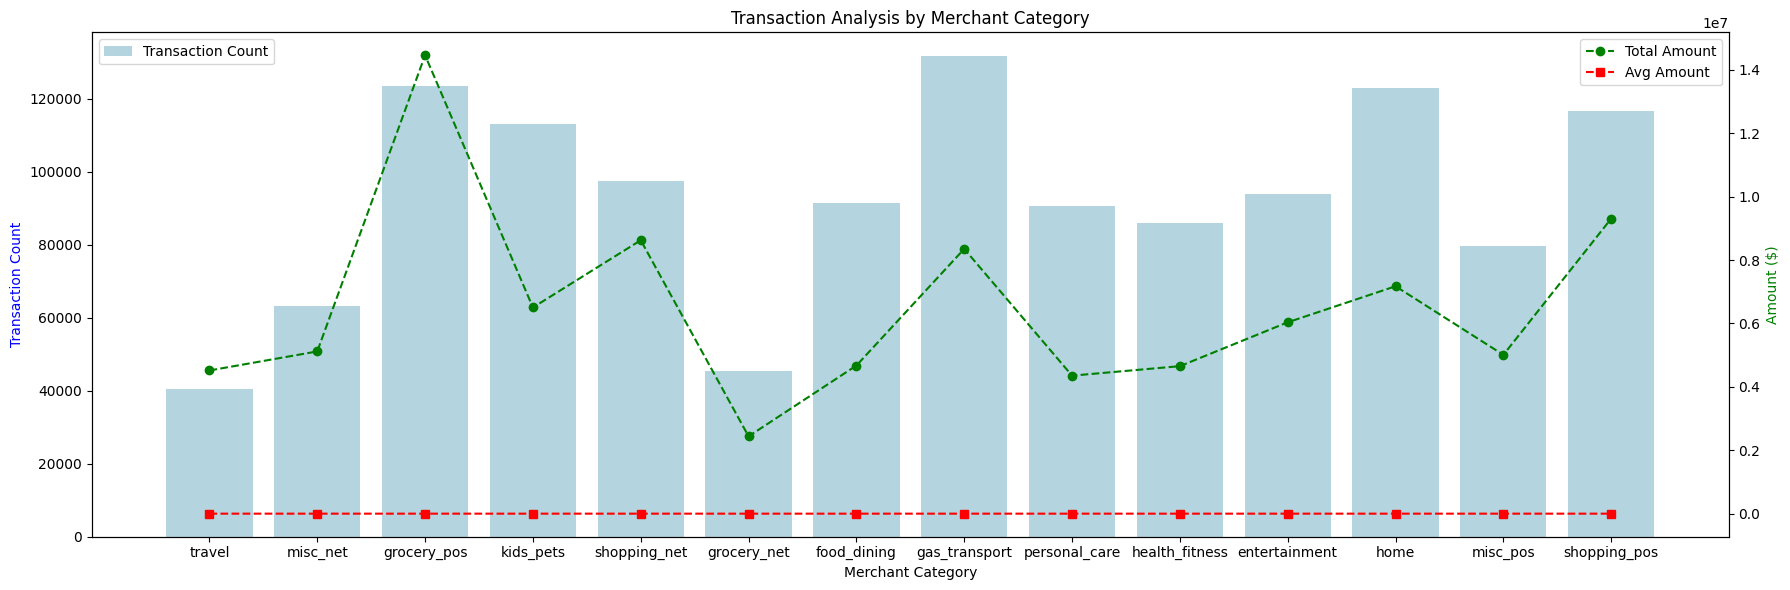

In [13]:
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot 'count' as bars
sns.barplot(x="category", y="count", data=pd_df, ax=ax1, color="lightblue", label="Transaction Count")


# Create second y-axis (right) for sum and average
ax2 = ax1.twinx()
ax2.plot(pd_df["category"],pd_df["sum"], color="green", marker="o", linestyle="dashed", label="Total Amount")
ax2.plot(pd_df["category"], pd_df["avg_amount"], color="red", marker="s", linestyle="dashed", label="Avg Amount")

# Labeling
ax1.set_xlabel("Merchant Category")
ax1.set_ylabel("Transaction Count", color="blue")
ax2.set_ylabel("Amount ($)", color="green")
plt.title("Transaction Analysis by Merchant Category")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
fig = px.choropleth(state_df, 
                    locations="state", 
                    locationmode="USA-states", 
                    color="count", 
                    color_continuous_scale="Reds",  # Choose from 'Viridis', 'Reds', 'Blues', etc.
                    scope="usa",
                    title="Transaction Count by State")

fig.show()

In [22]:
fig = px.choropleth(fr_s_df, 
                    locations="state", 
                    locationmode="USA-states", 
                    color="count", 
                    color_continuous_scale="Reds",  # Choose from 'Viridis', 'Reds', 'Blues', etc.
                    scope="usa",
                    title="Transaction Count by State")

fig.show()

In [15]:
fig = px.bar(
    mf_df,
    x="category",
    y="count",
    color="gender",
    barmode="group",  # 'group' creates clustered bars
    title="Transaction Count by Merchant Category and Gender",
    labels={"merchant_category": "Merchant Category", "transaction_count": "Transaction Count", "gender": "Gender"}
)

fig.show()

In [25]:
fig = px.bar(
    fr_c_df,
    x="category",
    y="count",
    color="is_fraud",
    barmode="group",  # 'group' creates clustered bars
    title="Transaction Count by Merchant Category and Gender",
    labels={"merchant_category": "Merchant Category", "transaction_count": "Transaction Count"}
)

fig.show()